# **PART 1** CPU vs GPU Model Training

In [ ]:
# Step 0: Setup
!pip install torch torchvision --quiet

import torch
import torchvision
print("Torch version:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("⚠️  No GPU detected. In Colab, go to: Runtime > Change runtime type > Hardware accelerator > GPU")


Torch version: 2.8.0+cu126
CUDA available? True
GPU name: Tesla T4


In [ ]:
# Step 1: Define model + utilities
import time, random, numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Simple CNN for MNIST
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_one_epoch(model, loader, device, optimizer, criterion):
    model.train()
    if device.type == "cuda": torch.cuda.synchronize()
    t0 = time.perf_counter()

    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    if device.type == "cuda": torch.cuda.synchronize()
    t1 = time.perf_counter()
    return (t1 - t0), running_loss / len(loader.dataset)


In [ ]:
# Step 2: Run training on a chosen device
def run_training(device_str='cpu', epochs=3, batch_size=128):
    set_seed(0)
    device = torch.device(device_str)
    print(f"\nRunning on {device}")

    # Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=(device.type=='cuda'))

    model = SmallCNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    epoch_times = []
    for ep in range(epochs):
        et, loss = train_one_epoch(model, loader, device, optimizer, criterion)
        epoch_times.append(et)
        print(f"Epoch {ep+1}/{epochs}: time={et:.2f}s loss={loss:.4f}")

    total = sum(epoch_times)
    avg = total / len(epoch_times)
    print(f"\n{device} total time: {total:.2f}s | avg/epoch: {avg:.2f}s")

    if device.type == 'cuda':
        print(f"Peak GPU memory: {torch.cuda.max_memory_allocated(device)/1024**2:.2f} MiB")
        torch.cuda.empty_cache()
    return total


In [ ]:
# Step 3: Run CPU vs GPU and compare
cpu_time = run_training('cpu', epochs=3, batch_size=128)

gpu_time = None
if torch.cuda.is_available():
    gpu_time = run_training('cuda', epochs=3, batch_size=128)

if gpu_time:
    speedup = cpu_time / gpu_time
    print(f"\n✅ Speedup = CPU_time / GPU_time = {speedup:.2f}×")
else:
    print("\n⚠️ GPU not available. Enable it in Runtime > Change runtime type > GPU.")



Running on cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 517kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.70MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.09MB/s]


Epoch 1/3: time=57.39s loss=0.2750
Epoch 2/3: time=48.19s loss=0.0641
Epoch 3/3: time=47.21s loss=0.0461

cpu total time: 152.79s | avg/epoch: 50.93s

Running on cuda
Epoch 1/3: time=12.60s loss=0.2750
Epoch 2/3: time=12.11s loss=0.0642
Epoch 3/3: time=12.07s loss=0.0466

cuda total time: 36.78s | avg/epoch: 12.26s
Peak GPU memory: 80.19 MiB

✅ Speedup = CPU_time / GPU_time = 4.15×


In [ ]:
!watch -n 1 nvidia-smi


>

# **PART 2** Effect of batch training

In [ ]:
def run_batch_experiment(batch_size=128, epochs=2, device='cuda'):
    set_seed(0)
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    print(f"\nBatch size {batch_size} on {device}")

    # Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST('./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=(device.type=='cuda'))
    test_loader = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=2)

    model = SmallCNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    epoch_times = []
    for ep in range(epochs):
        model.train()
        if device.type == 'cuda': torch.cuda.synchronize()
        t0 = time.perf_counter()

        for xb, yb in train_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        if device.type == 'cuda': torch.cuda.synchronize()
        epoch_time = time.perf_counter() - t0
        epoch_times.append(epoch_time)

    # evaluate accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    acc = 100 * correct / total

    peak_mem = torch.cuda.max_memory_allocated(device)/1024**2 if device.type=='cuda' else None
    return {
        'batch': batch_size,
        'epoch_time': np.mean(epoch_times),
        'acc': acc,
        'mem': peak_mem
    }


In [ ]:
batch_sizes = [16, 64, 256, 1024]
results = []

for b in batch_sizes:
    res = run_batch_experiment(batch_size=b, epochs=2, device='cuda')
    results.append(res)

import pandas as pd
df = pd.DataFrame(results)
df



Batch size 16 on cuda

Batch size 64 on cuda

Batch size 256 on cuda

Batch size 1024 on cuda


,batch,epoch_time,acc,mem
0,16,22.743194,99.03,167.650391
1,64,13.329770,98.49,167.650391
2,256,10.380241,97.76,169.181641
3,1024,10.165397,95.13,537.148438


In [ ]:
# Safe setup cell before Step 4
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import pandas as pd


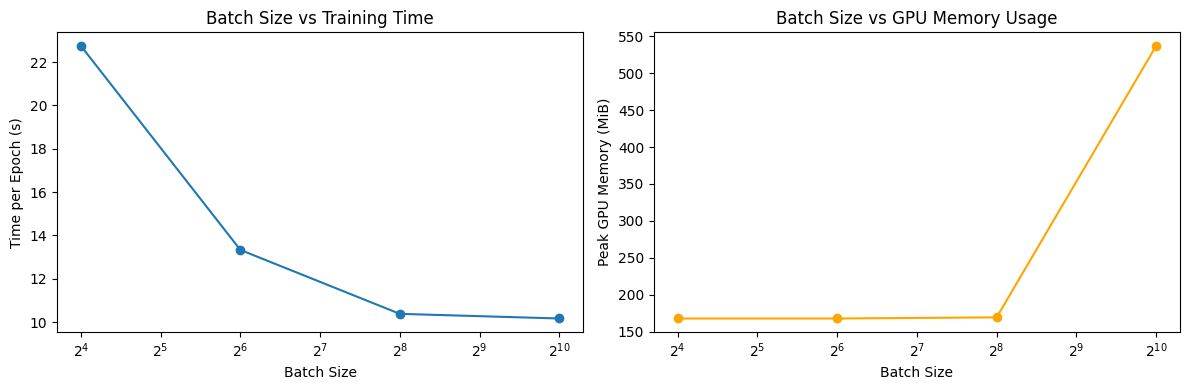

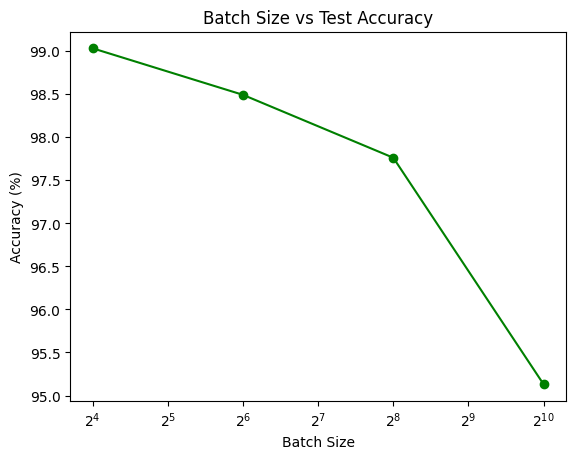

In [ ]:
plt.figure(figsize=(12,4))

# Plot 1: Batch size vs time per epoch
plt.subplot(1,2,1)
plt.plot(df['batch'], df['epoch_time'], marker='o')
plt.xscale('log', base=2)
plt.xlabel('Batch Size')
plt.ylabel('Time per Epoch (s)')
plt.title('Batch Size vs Training Time')

# Plot 2: Batch size vs memory usage
plt.subplot(1,2,2)
plt.plot(df['batch'], df['mem'], marker='o', color='orange')
plt.xscale('log', base=2)
plt.xlabel('Batch Size')
plt.ylabel('Peak GPU Memory (MiB)')
plt.title('Batch Size vs GPU Memory Usage')

plt.tight_layout()
plt.show()

# Optional accuracy trend
plt.figure()
plt.plot(df['batch'], df['acc'], marker='o', color='green')
plt.xscale('log', base=2)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Batch Size vs Test Accuracy')
plt.show()


# **Part 3:** Model Complexity and GPU Utilization

In [ ]:
!pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time, pandas as pd, matplotlib.pyplot as plt

# Check GPU
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Please enable GPU in Runtime settings.")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)


CUDA available: True
GPU: Tesla T4


In [ ]:
# Small: 2-layer MLP
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Medium: 4-layer MLP
class MediumModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Large: CNN with several convolutional layers
class LargeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute flattened feature map automatically
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = F.relu(self.conv1(x))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = F.relu(self.conv4(x))
            flat_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flat_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_one_epoch(model, loader, device, optimizer, criterion):
    model.train()
    if device.type == "cuda":
        torch.cuda.synchronize()
    start = time.perf_counter()

    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.perf_counter()
    return (end - start), total_loss / len(loader.dataset)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

models = {
    "Small": SmallModel(),
    "Medium": MediumModel(),
    "LargeCNN": LargeCNN()
}

results = []

for name, model in models.items():
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    print(f"\n🔹 Training {name} model")
    torch.cuda.reset_peak_memory_stats(device)

    epoch_time, loss = train_one_epoch(model, train_loader, device, optimizer, criterion)
    peak_mem = torch.cuda.max_memory_allocated(device) / 1024**2  # Convert to MB

    # Check GPU utilization snapshot
    !nvidia-smi --query-gpu=utilization.gpu,memory.used --format=csv,noheader,nounits | head -n 1

    results.append({
        "Model": name,
        "Epoch Time (s)": round(epoch_time, 2),
        "Peak GPU Memory (MiB)": round(peak_mem, 2),
        "Params (M)": round(sum(p.numel() for p in model.parameters()) / 1e6, 3)
    })

df_complexity = pd.DataFrame(results)
df_complexity



🔹 Training Small model
2, 986

🔹 Training Medium model
3, 986

🔹 Training LargeCNN model
44, 986


,Model,Epoch Time (s),Peak GPU Memory (MiB),Params (M)
0,Small,20.02,18.48,0.102
1,Medium,11.66,24.16,0.567
2,LargeCNN,12.52,220.39,1.995


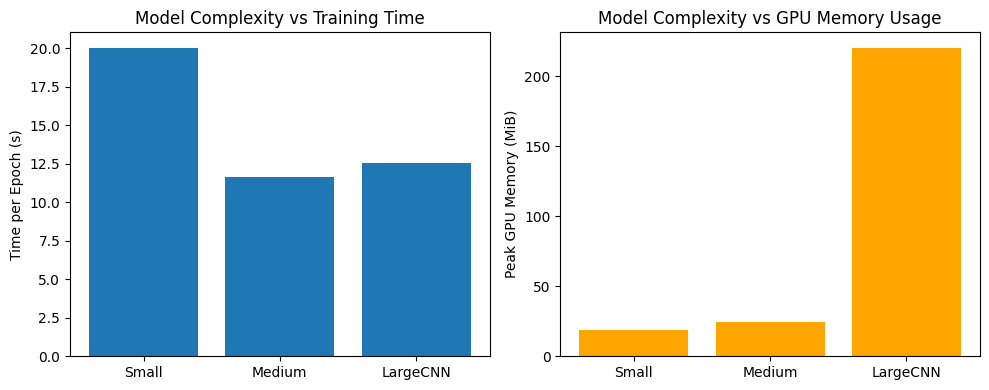


Model Details:


,Model,Epoch Time (s),Peak GPU Memory (MiB),Params (M)
0,Small,20.02,18.48,0.102
1,Medium,11.66,24.16,0.567
2,LargeCNN,12.52,220.39,1.995


In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(df_complexity['Model'], df_complexity['Epoch Time (s)'])
plt.ylabel("Time per Epoch (s)")
plt.title("Model Complexity vs Training Time")

plt.subplot(1,2,2)
plt.bar(df_complexity['Model'], df_complexity['Peak GPU Memory (MiB)'], color='orange')
plt.ylabel("Peak GPU Memory (MiB)")
plt.title("Model Complexity vs GPU Memory Usage")

plt.tight_layout()
plt.show()

print("\nModel Details:")
display(df_complexity)


# **Part 4:** Data Loading and Bottlenecks

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time, pandas as pd, matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reuse MNIST dataset if already loaded
try:
    train_ds
except NameError:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)


Using device: cuda


In [ ]:
class TinyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

criterion = nn.CrossEntropyLoss()


In [ ]:
def benchmark_dataloader(num_workers):
    loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True)
    model = TinyNet().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    batch_times = []
    model.train()

    start = time.perf_counter()
    for xb, yb in loader:
        t0 = time.perf_counter()
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()
        batch_times.append(time.perf_counter() - t0)
    total_time = time.perf_counter() - start
    return total_time, sum(batch_times)/len(batch_times)


In [ ]:
results = []
for workers in [0, 2, 4, 8]:
    print(f"\nTesting with num_workers = {workers} ...")
    total, per_batch = benchmark_dataloader(workers)
    results.append({
        "num_workers": workers,
        "Total Time (s)": round(total, 2),
        "Avg Batch Time (s)": round(per_batch, 4)
    })

df_workers = pd.DataFrame(results)
df_workers



Testing with num_workers = 0 ...

Testing with num_workers = 2 ...

Testing with num_workers = 4 ...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Testing with num_workers = 8 ...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


,num_workers,Total Time (s),Avg Batch Time (s)
0,0,18.51,0.0016
1,2,10.86,0.0028
2,4,11.29,0.0046
3,8,11.61,0.0079


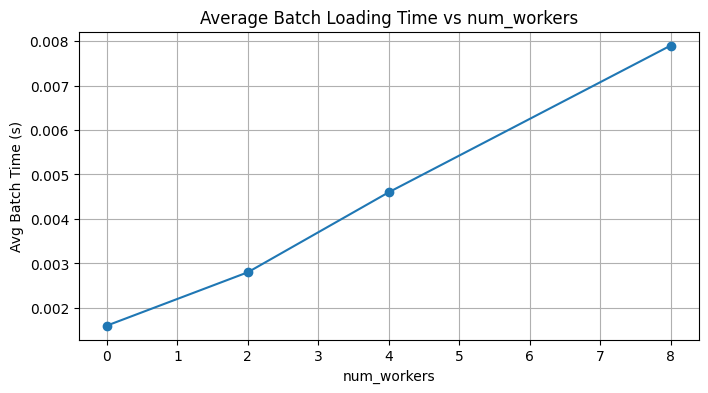

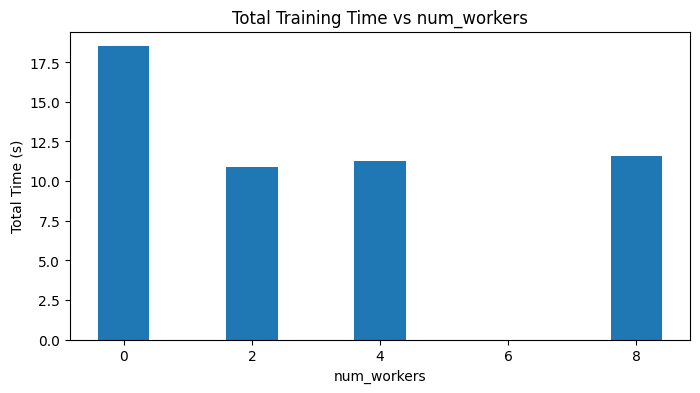


Summary:


,num_workers,Total Time (s),Avg Batch Time (s)
0,0,18.51,0.0016
1,2,10.86,0.0028
2,4,11.29,0.0046
3,8,11.61,0.0079


In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_workers["num_workers"], df_workers["Avg Batch Time (s)"], marker="o")
plt.title("Average Batch Loading Time vs num_workers")
plt.xlabel("num_workers")
plt.ylabel("Avg Batch Time (s)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df_workers["num_workers"], df_workers["Total Time (s)"])
plt.title("Total Training Time vs num_workers")
plt.xlabel("num_workers")
plt.ylabel("Total Time (s)")
plt.show()

print("\nSummary:")
display(df_workers)


# **Part 5:** Mixed Precision Training (Optional, Bonus)

In [ ]:
!pip install torch torchvision matplotlib --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time, pandas as pd, matplotlib.pyplot as plt

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)


CUDA available: True
GPU: Tesla T4


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
def train_one_epoch(model, loader, device, optimizer, criterion, use_amp=False):
    model.train()

    # Use new API (torch.amp instead of torch.cuda.amp)
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    if device.type == "cuda":
        torch.cuda.synchronize()
    start = time.perf_counter()
    total_loss = 0

    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=use_amp):
            preds = model(xb)
            loss = criterion(preds, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * xb.size(0)

    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.perf_counter()
    return end - start, total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            _, pred = torch.max(out, 1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    return correct / total


In [ ]:
criterion = nn.CrossEntropyLoss()
results = []

for mode in ["FP32 (no AMP)", "FP16 (with AMP)"]:
    print(f"\n🔹 Training Mode: {mode}")
    use_amp = "AMP" in mode
    model = SimpleCNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    torch.cuda.reset_peak_memory_stats(device)
    epoch_time, train_loss = train_one_epoch(model, train_loader, device, optimizer, criterion, use_amp=use_amp)
    acc = evaluate(model, test_loader, device)
    peak_mem = torch.cuda.max_memory_allocated(device) / 1024**2

    results.append({
        "Mode": mode,
        "Epoch Time (s)": round(epoch_time, 2),
        "Accuracy (%)": round(acc * 100, 2),
        "Peak GPU Memory (MiB)": round(peak_mem, 2)
    })

df_amp = pd.DataFrame(results)
df_amp



🔹 Training Mode: FP32 (no AMP)

🔹 Training Mode: FP16 (with AMP)


,Mode,Epoch Time (s),Accuracy (%),Peak GPU Memory (MiB)
0,FP32 (no AMP),19.99,97.77,297.44
1,FP16 (with AMP),11.85,97.13,297.21


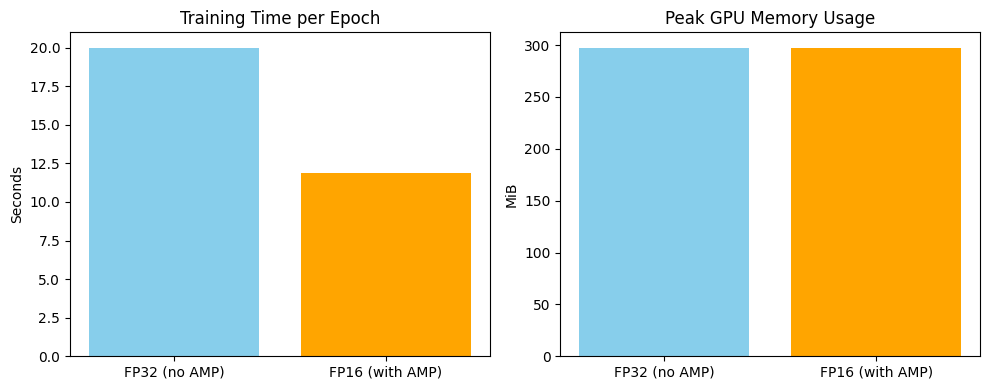


Summary:


,Mode,Epoch Time (s),Accuracy (%),Peak GPU Memory (MiB)
0,FP32 (no AMP),19.99,97.77,297.44
1,FP16 (with AMP),11.85,97.13,297.21


In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(df_amp["Mode"], df_amp["Epoch Time (s)"], color=["skyblue","orange"])
plt.title("Training Time per Epoch")
plt.ylabel("Seconds")

plt.subplot(1,2,2)
plt.bar(df_amp["Mode"], df_amp["Peak GPU Memory (MiB)"], color=["skyblue","orange"])
plt.title("Peak GPU Memory Usage")
plt.ylabel("MiB")

plt.tight_layout()
plt.show()

print("\nSummary:")
display(df_amp)
